In [1]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
import base64
import pickle
from sympy import symbols, MatrixSymbol, lambdify, Matrix, pprint

from scipy.optimize import minimize
from matplotlib.ticker import FuncFormatter
from sympy import symbols, MatrixSymbol, lambdify
from matplotlib import cm
import random
import matplotlib.colors as mcolors
import scipy
import time
from pathlib import Path
import os
import ast
import pandas as pd
from pathlib import Path
from matplotlib.ticker import ScalarFormatter


import pennylane as qml
from functools import partial
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import autograd
from pennylane.wires import Wires
import matplotlib.cm as cm
import base64
from qiskit import *
from qiskit.quantum_info import *
import os
import pickle
import re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


from readin_data_runs import process_new_files_analog,get_cached_data_once_analog,save_cached_data

# Global variable to store cached data in memory
global_cache_data_analog = set()
global_processed_files_analog = set()


In [2]:

num_epochs = 1500
# # Process files by each N_ctrl and update the cache independently
# cached_data_analog_nctrl3 , processed_files_analog_nctrl3 = get_cached_data_direct_path(nctrl3_path, N_ctrl)
# Main loop for different N_ctrl values
N_ctrls = [1, 2, 3]
num_train = 20
reservoir_counts = [1, 2, 3,4,5,6,7,8]
base_path = f'/Users/so714f/Documents/offline/qrc/analog_results_trainable_global/trainsize_{num_train}_epoch{num_epochs}_per_param3_opt/0/'
# base_path = f'/Users/so714f/Documents/offline/qrc/analog_results_trainable_global/trainsize_{num_train}_epoch1000/0/'
cached_data_analog, processed_files_analog = get_cached_data_once_analog(base_path)

[INFO] Cache file /Users/so714f/Documents/offline/qrc/analog_results_trainable_global/trainsize_20_epoch1500_per_param3_opt/0/cached_results.pkl does not exist. Creating empty cache.


In [3]:
trots = np.arange(0, 25, 2)
trots = [2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24]

In [4]:
N_ctrls = [1, 2]
reservoir_counts = [1, 2, 3,4,5,6,7,8]
for N_ctrl in N_ctrls:
    
    gate_prefixes = [f'U{N_ctrl}']
    


    # trots = np.arange(1, 25, 1)

    # Process files and update the cache
    cached_data_analog, processed_files_analog  = process_new_files_analog(base_path, gate_prefixes, reservoir_counts, trots, cached_data_analog, processed_files_analog, N_ctrl)
  
    save_cached_data(base_path, cached_data_analog, processed_files_analog )

    global_processed_files_analog.update(processed_files_analog)

[process_new_files_analog] Processing for N_ctrl = 1
[process_new_files_analog] Processing for N_ctrl = 2
[process_new_files_analog] U2_0, N_c=2, N_R=1, T=6, num files(runs)= 1
[process_new_files_analog] U2_0, N_c=2, N_R=1, T=8, num files(runs)= 1
[process_new_files_analog] U2_0, N_c=2, N_R=1, T=10, num files(runs)= 2
[process_new_files_analog] U2_0, N_c=2, N_R=1, T=12, num files(runs)= 1
[process_new_files_analog] U2_0, N_c=2, N_R=1, T=14, num files(runs)= 1
[process_new_files_analog] U2_0, N_c=2, N_R=1, T=18, num files(runs)= 2
[process_new_files_analog] U2_0, N_c=2, N_R=1, T=20, num files(runs)= 1
[process_new_files_analog] U2_0, N_c=2, N_R=1, T=22, num files(runs)= 1
[process_new_files_analog] U2_1, N_c=2, N_R=1, T=6, num files(runs)= 1
[process_new_files_analog] U2_1, N_c=2, N_R=1, T=8, num files(runs)= 1
[process_new_files_analog] U2_1, N_c=2, N_R=1, T=10, num files(runs)= 1
[process_new_files_analog] U2_1, N_c=2, N_R=1, T=12, num files(runs)= 1
[process_new_files_analog] U2_1, N

In [5]:
def get_dataframe(cached_data_temp, model_type = "Digital",N_ctrls = [1]):
    for N_ctrl in cached_data_temp:
        for gate, gate_data in cached_data_temp[N_ctrl].items():
            for reservoir_count, res_data in gate_data.items():
                for trotter_step, results_list in res_data.items():
                    for results in results_list:
                        original = results.get('test_results', [])
                        new_vals = []
                        for f in original:
                            if f > 1.0:
                                delta = f - 1.0       # how far above 1.0
                                reflected = 1.0 - delta  # reflect about 1.0
                                # If 'reflected' dips below 0 (which can happen if f>2),
                                # you might clamp it to 0.0 or do something else:
                                if reflected < 0:
                                    reflected = 0.0
                                print(f"[PASS 1] Reflecting fidelity {f:.6f} about 1.0 => {reflected:.6f} "
                                    f"(Gate={gate}, N_C={N_ctrl}, N_R={reservoir_count}, T={trotter_step})")
                                new_vals.append(reflected)
                            else:
                                new_vals.append(f)
                        results['test_results'] = new_vals
    for N_ctrl in cached_data_temp:
        for gate, gate_data in cached_data_temp[N_ctrl].items():
            for reservoir_count, res_data in gate_data.items():
                for trotter_step, results_list in res_data.items():
                    for results in results_list:
                        # Just clamp any test_results fidelity to <= 1.0
                        original = results.get('test_results', [])
                        clamped_vals = [min(1.0, f) for f in original]
                        results['test_results'] = clamped_vals
                        
    tmp_rows = []
    for N_ctrl in cached_data_temp:
        for gate, gate_data in cached_data_temp[N_ctrl].items():
            for reservoir_count, res_data in gate_data.items():
                for trotter_step, results_list in res_data.items():
                    for results in results_list:
                        row = {
                            'Type': model_type,
                            'N_C': N_ctrl,
                            'Gate': gate,
                            'N_R': reservoir_count,
                            'Trotter_Step': trotter_step,
                        }
                        # Include *all* keys from `results` so we don't drop anything
                        for k, v in results.items():
                            row[k] = v

                        tmp_rows.append(row)

    tmp_df = pd.DataFrame(tmp_rows)
        
   

    def keep_iqr_5_95(arr):
        # If array empty or all identical, just return it
        if len(arr) < 2:
            return arr
        p5, p95 = np.percentile(arr, [0, 95])
        filtered = [x for x in arr if p5 <= x <= p95]
        # If everything got filtered out, you could decide to keep them all
        # or do something else. Here we allow an empty list if it's all outliers.
        return filtered if filtered else arr

    # tmp_df['test_results'] = tmp_df['test_results'].apply(keep_iqr_5_95)

    tmp_df['avg_fidelity'] = tmp_df['test_results'].apply(
        lambda arr: np.mean(arr) if len(arr) else 1.0
    )

    group_cols = ['N_C', 'N_R', 'Trotter_Step']
    tmp_df['local_max_avg_fid'] = (
        tmp_df.groupby(group_cols)['avg_fidelity'].transform('max')
    )


    def fix_any_ones_partially(row):
        arr = row['test_results']
        if len(arr) > 0 and any(x == 1.0 for x in arr):
            local_max = row['local_max_avg_fid']
            new_arr = []
            for x in arr:
                if x == 1.0:
                    new_arr.append(local_max)
                else:
                    new_arr.append(x)
            print(f"[PASS 2] Partially replacing any 1.0 entries "
                f"with local_max_avg_fid={local_max:.4e} "
                f"(Gate={row['Gate']}, N_C={row['N_C']}, "
                f"N_R={row['N_R']}, T={row['Trotter_Step']})")
            return new_arr
        return arr
    tmp_df['test_results'] = tmp_df.apply(fix_any_ones_partially, axis=1)

    
    ##############################################################################
    # WRITE BACK THE UPDATED `test_results` INTO `cached_data_temp`
    # so your original code snippet can run unmodified.
    ##############################################################################
    for idx, row in tmp_df.iterrows():
        N_ctrl = row['N_C']
        gate = row['Gate']
        reservoir_count = row['N_R']
        trotter_step = row['Trotter_Step']
        
        # Find matching entry in the results_list
        results_list = cached_data_temp[N_ctrl][gate][reservoir_count][trotter_step]
        found_entry = False
        for results in results_list:
            # If you have a unique 'run' key, match on that
            if 'run' in row and results.get('run') == row['run']:
                results['test_results'] = row['test_results']
                found_entry = True
                break

        # If you have no unique ID, you must figure out a safe way to match
        # For now, we skip if not found:
        if not found_entry:
            pass



    ##############################################################################
    # PASS 2: RUN YOUR ORIGINAL CODE TO BUILD THE FINAL `all_data_df` WITH ALL KEYS
    ##############################################################################
    rows = []
    negative_fidelity_values = []
    def keep_iqr_5_95(arr,a = 5,b = 95):
        # If array empty or all identical, just return it
        if len(arr) < 2:
            return arr
        p5, p95 = np.percentile(arr, [a, b])
        filtered = [x for x in arr if p5 <= x <= p95]
        # If everything got filtered out, you could decide to keep them all
        # or do something else. Here we allow an empty list if it's all outliers.
        return filtered if filtered else arr
    global_min_error = 100  # from your snippet

    for N_ctrl in N_ctrls:
        data_i = cached_data_temp[N_ctrl]
        for gate, gate_data in data_i.items():
            for reservoir_count, res_data in gate_data.items():
                for trotter_step, results_list in res_data.items():
                    for results in results_list:
                        avg_fidelity = results.get('fidelity', np.nan)
                        std_fidelity = np.nanstd(results.get('test_results', []))

                        if pd.isna(avg_fidelity):
                            raise ValueError(
                                f"NaN in avg_fidelity! Gate: {gate}, N_C: {N_ctrl}, "
                                f"N_R: {reservoir_count}, Trotter_Step: {trotter_step}, "
                                f"Run: {results.get('run', None)}"
                            )

                        log_infidelities = []
                        infidelities, fidelities = [], []
                        num_clipped = {}
                        all_og_fidelities = {}

                        test_results = results.get('test_results', [])
                        optimal_min_error = None
                        optimal_jitter_scale = None

                        # Step 1: dynamic min_error + jitter
                        non_clipped_fids = [
                            f for f in test_results
                            if 0 < f < 1.0
                        ]
                        if non_clipped_fids:
                            sorted_valid = sorted(non_clipped_fids)
                            n = len(sorted_valid)
                            std_dev = np.std(sorted_valid)
                            std_err = std_dev / np.sqrt(n) if n > 1 else global_min_error
                            optimal_min_error = 1.0 - sorted_valid[-1]
                            if global_min_error > optimal_min_error:
                                global_min_error = max(1e-9, optimal_min_error)
                            optimal_jitter_scale = (
                                std_dev / 2
                                if std_dev/2 < optimal_min_error
                                else optimal_min_error
                            )
                        else:
                            optimal_min_error = global_min_error
                            optimal_jitter_scale = global_min_error

                        # Step 2: Process each fidelity
                        clipped_count = 0
                        for i, f in enumerate(test_results):
                            all_og_fidelities[i] = f
                            inf = 1.0 - f

                            if inf <= 1e-8:
                                clipped_count += 1
                                jitter = np.random.uniform(-optimal_jitter_scale, 
                                                        optimal_jitter_scale)
                                num_clipped[i] = {'fidelity': f, 'jit': jitter}
                                inf = optimal_min_error + jitter
                                # print(f'triggered')
                                # print(f"\nGate={results['gate']} => test_results stats:")
                                # print(f"  Min={np.min(test_results):.7e}, Max={np.max(test_results)}, Var={np.var(test_results)}, Mean={np.mean(test_results):.9f}")
                                assert inf > 0, (
                                    f"Adjusted infidelity is non-positive: i={i}, "
                                    f"min_error={optimal_min_error}, jitter={jitter}."
                                )
                                f = 1.0 - inf

                            infidelities.append(inf)
                            fidelities.append(f)
                            log_infidelities.append(np.log10(inf))

                        # Step 3: Build row
                        avg_fidelity = np.mean(fidelities)
                        avg_infidelity = np.mean(infidelities)

                        row = {
                            'Type': model_type,
                            'N_C': int(N_ctrl),
                            'Trotter_Step': int(trotter_step),
                            'Gate': results['gate'],
                            'N_R': int(reservoir_count),
                            'Avg_Fidelity': avg_fidelity,
                            'std_fidelity': std_fidelity,
                            'Avg_infidelity': avg_infidelity,
                            'var_infid': np.var(infidelities),
                            'Error_Test_Results': keep_iqr_5_95(log_infidelities,a=10,b=100),
                            'Avg Error': (np.nanmean(log_infidelities) 
                                        if log_infidelities else np.nan),
                            'infidelities': keep_iqr_5_95(infidelities, a = 20, b = 100),
                            'fidelities':  keep_iqr_5_95(fidelities, a = 0, b = 95),
                            'Costs': results.get('costs', []),
                            'Test Results': test_results,
                            'N_params': results.get('param_count', np.nan),
                            'run': results.get('run', None),
                           
                          
                        }

                        rows.append(row)

    all_data_df = pd.DataFrame(rows)
    return all_data_df
print(cached_data_analog.keys())
all_data_df = get_dataframe(cached_data_analog, "Analog", N_ctrls=[2])

dict_keys([2])


global_min_y: -6.847191885529103, global_max_y: -0.07350132182126991
global_min_fidelity: 0.821755814795196, global_max_fidelity: 0.999999156421423


/var/folders/_n/l6510w3x7l7dl_qw6crm6t540000gr/T/ipykernel_19667/997633737.py:116: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.violinplot(x='Trotter_Step', y='Error_Test_Results', hue='N_R', data=test_results_df,


y ticks: [-8. -7. -6. -5. -4. -3. -2. -1.  0.  1.], -7
[-6. -5. -4. -3. -2. -1.  0.]


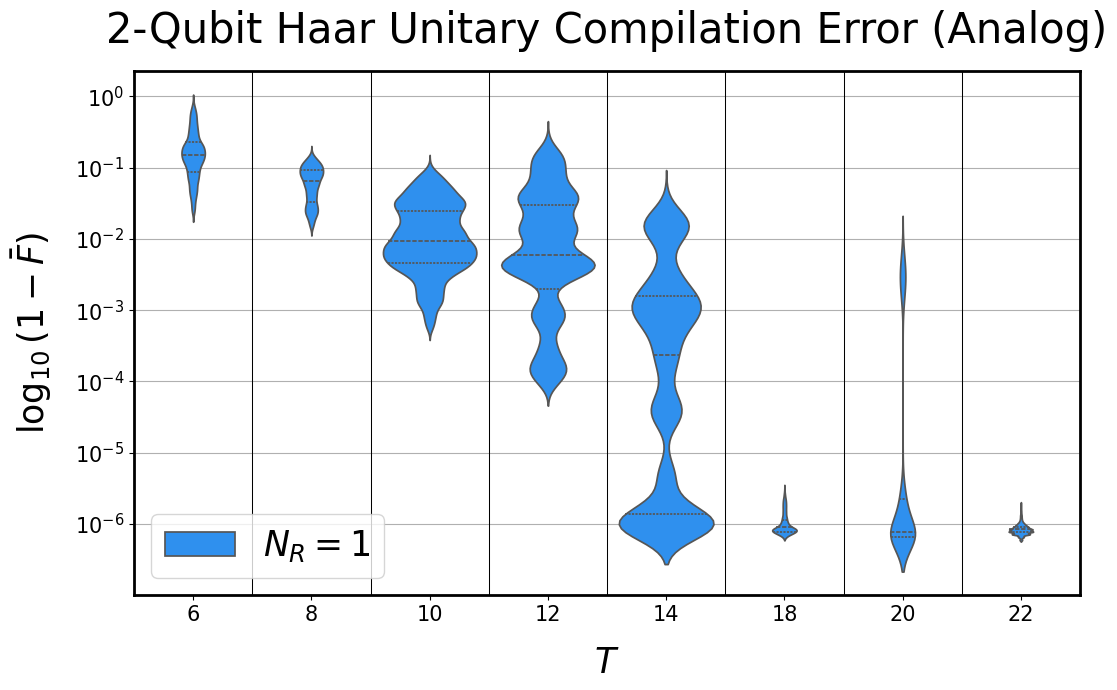

y ticks: [-10.  -8.  -6.  -4.  -2.   0.   2.]


/var/folders/_n/l6510w3x7l7dl_qw6crm6t540000gr/T/ipykernel_19667/997633737.py:180: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.violinplot(x='Trotter_Step', y='Avg Error', hue='N_R', data=data_filtered,


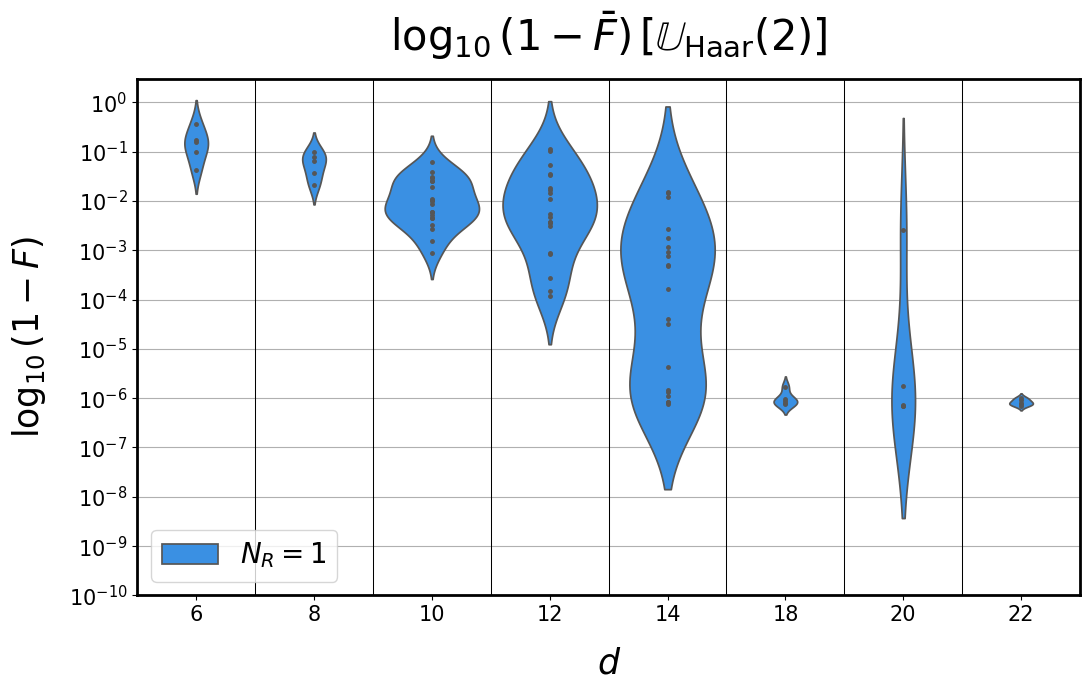

In [7]:
# Initialize variables to store global min and max y-values
global_min_y = float('inf')
global_max_y = float('-inf')
global_min_fidelity = float('inf')
global_max_fidelity = float('-inf')

custom_palette = ['dodgerblue', 'gold', 'violet'] 
plt.close('all')  # Close previous figures to avoid conflicts
N_ctrls = [2]
resies = [1,2,3,4,5,6,7,8,9]
resies = [1]
for N_ctrl in N_ctrls:
    trots = np.arange(1,54,1)
    
    if N_ctrl == 2:
        trots = set(trots)
        # trots.remove(np.int64(6))
        
    elif N_ctrl == 1:
        trots = set(trots)
        
    elif N_ctrl == 3:
        trots = set(trots)
        trots.remove(np.int64(32))
        trots.remove(np.int64(36))
        trots.remove(np.int64(1))
        trots.remove(np.int64(42))
        trots.remove(np.int64(47))

    
    

    trots = list(trots)
   

    # Filter the DataFrame for specific N_C (control qubits)
    data_df = all_data_df[(all_data_df['N_C'] == N_ctrl) & (all_data_df['Trotter_Step'].isin(trots))]

    # Aggregate average fidelity by Trotter_Step and N_R
    aggregated_fidelity = data_df.groupby(['Trotter_Step', 'N_R'])['Avg_Fidelity'].mean().reset_index()

    # Get the min and max fidelity from aggregated results
    current_min_fidelity = aggregated_fidelity['Avg_Fidelity'].min()
    current_max_fidelity = aggregated_fidelity['Avg_Fidelity'].max()

    # Explode test results into separate rows to plot each error individually
    test_results_df_error = data_df.explode('Error_Test_Results').dropna(subset=['Error_Test_Results'])

    # Get min and max y-values for the current N_ctrl (log-error test results
    current_min_y = test_results_df_error['Error_Test_Results'].min()
    current_max_y = test_results_df_error['Error_Test_Results'].max()

    # Update global min/max values
    global_min_y = min(global_min_y, current_min_y)
    global_max_y = max(global_max_y, current_max_y)
    global_min_fidelity = min(global_min_fidelity, current_min_fidelity)
    global_max_fidelity = max(global_max_fidelity, current_max_fidelity)

# Add a slight margin to avoid cutoff on the plot
margin_factor = 0.1
global_min_y -= margin_factor * abs(global_min_y)
global_max_y += margin_factor * abs(global_max_y)

print(f"global_min_y: {global_min_y}, global_max_y: {global_max_y}")
print(f"global_min_fidelity: {global_min_fidelity}, global_max_fidelity: {global_max_fidelity}")
plot_avgered = True
custom_palette = ['dodgerblue', 'gold', 'violet'] 
# Now that we have the global y-limits, we can proceed to plotting
for N_ctrl in N_ctrls:
    trots = np.arange(1,54,1)
    
    if N_ctrl == 2:
        trots = set(trots)
        # trots.remove(np.int64(6))
        
    elif N_ctrl == 1:
        trots = set(trots)
        
    elif N_ctrl == 3:
        trots = set(trots)
        trots.remove(np.int64(32))
        trots.remove(np.int64(36))
        trots.remove(np.int64(1))
        trots.remove(np.int64(42))
        trots.remove(np.int64(47))
    trots = list(trots)

    # Filter the DataFrame for specific N_C (control qubits)
    data_df = all_data_df[all_data_df['N_C'] == N_ctrl]
    data_df = data_df[data_df['Trotter_Step'].isin(trots)]
    data_df = data_df[data_df['N_R'].isin(resies)]

    # Explode test results into separate rows to plot each error individually
    test_results_df = data_df.explode('Error_Test_Results')

    # Find the common Trotter steps across all N_Rs
    grouped_trotter_steps = test_results_df.groupby(['Trotter_Step', 'N_R']).size().unstack(fill_value=0)
    valid_trotter_steps = grouped_trotter_steps[(grouped_trotter_steps > 0).all(axis=1)].index

    # Filter the DataFrame to only include those Trotter steps
    test_results_df = test_results_df[test_results_df['Trotter_Step'].isin(valid_trotter_steps)]

    # Drop rows with NaN values in 'Error_Test_Results' to avoid errors
    test_results_df = test_results_df.dropna(subset=['Error_Test_Results'])

    # Plot for each control qubit
    fig, axs = plt.subplots(1, figsize=(11, 7))

    # Set the linewidth of the outside border (spines)
    for spine in axs.spines.values():
        spine.set_linewidth(2)  # Set linewidth to 2 pixels

    # Violin plot for Error_Test_Results (log10(1 - Test Results))
    # sns.violinplot(x='Trotter_Step', y='infidelities', hue='N_R', data=test_results_df, 
    #                ax=axs,width=0.8, palette=custom_palette,log_scale=True, density_norm='count', inner='quartile', saturation=0.85)
    sns.violinplot(x='Trotter_Step', y='Error_Test_Results', hue='N_R', data=test_results_df, 
                   ax=axs,width=0.8, palette=custom_palette,density_norm='count', inner='quartile', saturation=0.85)

    # Set titles and labels with padding
    # axs.set_title(f"$\\log_{{10}}(1 - \\bar{{F}}) \\, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$", fontsize=30, pad=20)
    axs.set_title(f"{N_ctrl}-Qubit Haar Unitary Compilation Error (Analog)", fontsize=30, pad=20)
    
    axs.set_xlabel('$T$', fontsize=25, labelpad=15)  # X-axis label with padding
    axs.set_ylabel(r'$\log_{10}\left(1 - \bar{F}\right)$', fontsize=25, labelpad=15)  # Y-axis label with padding


    # Add grid lines
    axs.yaxis.grid(True)
    axs.xaxis.grid(False)
    axs.set_axisbelow(True)

    # Customize the legend
    handles, labels = axs.get_legend_handles_labels()
    axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=25)

    # # Set the global Y-limits
    # axs.set_ylim(global_min_y, global_max_y)

    # # Set Y-ticks and labels
    y_ticks = axs.get_yticks()
    print(f"y ticks: {y_ticks}, {round(global_min_y)}")
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    min_tick = round(global_min_y)
    max_tick = max(whole_y_ticks)
    whole_y_ticks = np.arange(min_tick+1, max_tick + 1, 1)
    print(whole_y_ticks)
    axs.set_yticks(whole_y_ticks)
    axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # Set tick parameters
    axs.tick_params(axis='y', labelsize=15)
    axs.tick_params(axis='x', labelsize=15)

    # Add vertical lines to separate groups
    unique_trotter_steps = test_results_df['Trotter_Step'].unique()
    positions = range(1, len(unique_trotter_steps), 1)
    for pos in positions:
        axs.axvline(x=pos - 0.5, color='black', linewidth=0.75)

    # Prevent clipping of y-axis ticks/labels
    # plt.tight_layout(pad=3.0)
    # plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9)

    # Show the plot for the current N_ctrl
    plt.tight_layout()
    plt.show()
    if plot_avgered:
        # Filter the DataFrame for specific Trotter_Steps
        data_filtered = data_df[data_df['Trotter_Step'].isin(trots)]

        ### First Violin Plot for Average Error ###

        fig, axs = plt.subplots(1, figsize=(11, 7))

        # Set the linewidth of the outside border (spines)
        for spine in axs.spines.values():
            spine.set_linewidth(2)  # Set linewidth to 2 pixels

        # Violin Plot for Average Error (log10(1 - avg_fidelity))
        sns.violinplot(x='Trotter_Step', y='Avg Error', hue='N_R', data=data_filtered, 
                    ax=axs, palette=custom_palette, density_norm='count', inner="point")

        # Set titles and labels with padding
        axs.set_title(r'$\log_{10}(1 - \bar{F}) \, [\mathbb{U}_{\text{Haar}}(2)]$', fontsize=30, pad=20)
        axs.set_xlabel('$d$', fontsize=25, labelpad=15)  # X-axis label with padding
        axs.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=25, labelpad=15)  # Y-axis label with padding

        # Add grid lines
        axs.yaxis.grid(True)
        axs.xaxis.grid(False)
        axs.set_axisbelow(True)

        # Customize the legend
        handles, labels = axs.get_legend_handles_labels()
        axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=20)

        # Set Y-ticks and labels
        y_ticks = axs.get_yticks()
        print(f"y ticks: {y_ticks}")
        whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
        # print(whole_y_ticks)
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
        # print(whole_y_ticks)
        
        axs.set_yticks(whole_y_ticks)
        axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

        # Set tick parameters
        axs.tick_params(axis='y', labelsize=15) 
        axs.tick_params(axis='x', labelsize=15) 

        # Add vertical lines to separate groups
        unique_trotter_steps = data_filtered['Trotter_Step'].unique()
        positions = range(1, len(unique_trotter_steps), 1)
        for pos in positions:
            axs.axvline(x=pos - 0.5, color='black', linewidth=0.75)

        # Show the plot
        plt.tight_layout()
        plt.show()

In [10]:
# filtered__trot_20 = all_data_df[(all_data_df["N_R"] == 1) & (all_data_df["Trotter_Step"] == 22) & (all_data_df["Avg Error"] > -5.75) & (all_data_df["Gate_idx"] <20)]
filtered__trot_20 = all_data_df[(all_data_df["N_R"] == 1) & (all_data_df["Trotter_Step"] == 12) & (all_data_df["Avg Error"] > -1.5)]
# filtered__trot_20 = all_data_df[(all_data_df["N_R"] == 1) & (all_data_df["Trotter_Step"] == 22) & (all_data_df["Avg Error"] > -5.75) ]
filtered__trot_20.head()

,Type,N_C,Trotter_Step,Gate,N_R,Avg_Fidelity,std_fidelity,Avg_infidelity,var_infid,Error_Test_Results,Avg Error,infidelities,fidelities,Costs,Test Results,N_params,run
17,Analog,2,12,U2_10,1,0.943449,0.020339,0.056551,0.000414,"[-1.0490127229929551, -1.4356852150818222, -1....",-1.278448,"[0.08932793140411377, 0.04412031173706055, 0.0...","[0.9106720685958862, 0.9633296728134155, 0.955...","[0.8163601756095886, 0.8031384348869324, 0.789...","[0.9106720685958862, 0.9633296728134155, 0.955...",39,data_run_0
23,Analog,2,12,U2_12,1,0.876793,0.048923,0.123207,0.002393,"[-0.9580842063183597, -1.0178292851784303, -1....",-0.946519,"[0.11013257503509521, 0.095977783203125, 0.093...","[0.8898674249649048, 0.904022216796875, 0.9062...","[0.7285428047180176, 0.7181739211082458, 0.701...","[0.8898674249649048, 0.904022216796875, 0.9062...",39,data_run_0
35,Analog,2,12,U2_16,1,0.888950,0.040318,0.111050,0.001626,"[-0.7630398257879759, -1.1224656396564918, -0....",-0.986760,"[0.1725679636001587, 0.075428307056427, 0.1195...","[0.8274320363998413, 0.924571692943573, 0.8804...","[0.8099361062049866, 0.7936760783195496, 0.773...","[0.8274320363998413, 0.924571692943573, 0.8804...",39,data_run_0
49,Analog,2,12,U2_2,1,0.963073,0.012554,0.036927,0.000158,"[-1.216860785585569, -1.5594100718570565, -1.6...",-1.461904,"[0.06069308519363403, 0.02757972478866577, 0.0...","[0.939306914806366, 0.9724202752113342, 0.9767...","[0.7800803780555725, 0.7510043978691101, 0.709...","[0.939306914806366, 0.9724202752113342, 0.9767...",39,data_run_0
65,Analog,2,12,U2_4,1,0.965087,0.009141,0.034913,0.000084,"[-1.4962232667013309, -1.3975516598572195, -1....",-1.473527,"[0.03189897537231445, 0.040035784244537354, 0....","[0.9681010246276855, 0.9599642157554626, 0.957...","[0.7421616315841675, 0.7248013615608215, 0.708...","[0.9681010246276855, 0.9599642157554626, 0.957...",39,data_run_0


In [11]:
len(filtered__trot_20)

5